In [2]:
import pandas as pd
import numpy as np

In [4]:
def load_sample_data():
    products = pd.read_csv('bid_allocation_model/sample_data/products.csv')
    suppliers = pd.read_csv('bid_allocation_model/sample_data/suppliers.csv')
    bids = pd.read_csv('bid_allocation_model/sample_data/bids.csv')

    return products, suppliers, bids

products, suppliers, bids = load_sample_data()

In [5]:
products.columns = ['prod_name', 'prod_desc', 'selling_price', 'demand']
products['prod_index'] = products.index
products

,prod_name,prod_desc,selling_price,demand,prod_index
0,Product A,Description for Product A,10,300,0
1,Product B,Description for Product B,20,200,1
2,Product C,Description for Product C,30,300,2


In [6]:
suppliers.columns = ['supp_name', 'supp_desc', 'trans_cost']
suppliers['sup_index'] = suppliers.index
suppliers

,supp_name,supp_desc,trans_cost,sup_index
0,Supplier X,Description for supplier X,21,0
1,Supplier Y,Description for supplier Y,23,1
2,Supplier Z,Description for supplier Z,24,2


In [7]:
bids.columns = ['prod_name', 'supp_name', 'bid_cost', 'other_cost']
bids['bid_index'] = bids.index
bids

,prod_name,supp_name,bid_cost,other_cost,bid_index
0,Product A,Supplier X,11,10,0
1,Product A,Supplier Y,14,20,1
2,Product A,Supplier Z,11,15,2
3,Product B,Supplier X,13,13,3
4,Product B,Supplier Y,14,9,4
5,Product B,Supplier Z,11,10,5
6,Product C,Supplier X,18,12,6
7,Product C,Supplier Y,20,13,7


In [8]:
complete_data = pd.merge(bids, products,on='prod_name',how='left')
complete_data = pd.merge(complete_data, suppliers, on = 'supp_name', how = 'left')
complete_data

,prod_name,supp_name,bid_cost,other_cost,bid_index,prod_desc,selling_price,demand,prod_index,supp_desc,trans_cost,sup_index
0,Product A,Supplier X,11,10,0,Description for Product A,10,300,0,Description for supplier X,21,0
1,Product A,Supplier Y,14,20,1,Description for Product A,10,300,0,Description for supplier Y,23,1
2,Product A,Supplier Z,11,15,2,Description for Product A,10,300,0,Description for supplier Z,24,2
3,Product B,Supplier X,13,13,3,Description for Product B,20,200,1,Description for supplier X,21,0
4,Product B,Supplier Y,14,9,4,Description for Product B,20,200,1,Description for supplier Y,23,1
5,Product B,Supplier Z,11,10,5,Description for Product B,20,200,1,Description for supplier Z,24,2
6,Product C,Supplier X,18,12,6,Description for Product C,30,300,2,Description for supplier X,21,0
7,Product C,Supplier Y,20,13,7,Description for Product C,30,300,2,Description for supplier Y,23,1


In [9]:

allocated_bid = {}
for bid_index in complete_data:
    allocated_bid[] = supplier_allocation_model.NewIntVar('bid_%s_%s', bids[bid_index]['Product Name'], bids[bid_index])

# Total bids should be less than or equal to demand


SyntaxError: invalid syntax (<ipython-input-9-335c3613b38a>, line 3)

In [10]:
from ortools.sat.python import cp_model
supplier_allocation_model = cp_model.CpModel()
max_demand = max(products.demand)

# Integer variables indicating the quantity that has to be allocated to each supplier
allocated_bid = {}
for row in complete_data.iterrows():
    prod_index = row[1].prod_index
    supp_index = row[1].sup_index
    allocated_bid[prod_index, supp_index] = \
        supplier_allocation_model.NewIntVar(0, max_demand, 'bid_'+ str(prod_index) + '_'+  str(supp_index))


In [11]:
# total sum allocated should be less than demand
for p in complete_data.prod_index.unique():
    total_demand_constraint = sum(allocated_bid[p, s] for s in \
        complete_data[complete_data.prod_index == p].sup_index.unique()) == \
    products.demand[p]
    supplier_allocation_model.Add(total_demand_constraint)
    print(total_demand_constraint)

(((bid_0_0) + bid_0_1) + bid_0_2) == 300
(((bid_1_0) + bid_1_1) + bid_1_2) == 200
((bid_2_0) + bid_2_1) == 300


In [12]:
# optimise for bid costs
total_cost = 0
for row in complete_data.iterrows():
    prod_index = row[1].prod_index
    supp_index = row[1].sup_index
    cost = int(row[1].bid_cost + row[1].other_cost + row[1].trans_cost)
    total_cost += allocated_bid[prod_index, supp_index]*cost
supplier_allocation_model.Minimize(total_cost)

In [13]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(supplier_allocation_model, solution_printer)

Solution 0, time = 0.01 s, objective = 36900


In [14]:
complete_data['solution'] = 0
for i, row in enumerate(complete_data.iterrows()):
    prod_index = row[1].prod_index
    supp_index = row[1].sup_index
    complete_data['solution'][i] = solver.Value(allocated_bid[prod_index, supp_index])

<ipython-input-14-79769336acc8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['solution'][i] = solver.Value(allocated_bid[prod_index, supp_index])


In [15]:
complete_data

,prod_name,supp_name,bid_cost,other_cost,bid_index,prod_desc,selling_price,demand,prod_index,supp_desc,trans_cost,sup_index,solution
0,Product A,Supplier X,11,10,0,Description for Product A,10,300,0,Description for supplier X,21,0,300
1,Product A,Supplier Y,14,20,1,Description for Product A,10,300,0,Description for supplier Y,23,1,0
2,Product A,Supplier Z,11,15,2,Description for Product A,10,300,0,Description for supplier Z,24,2,0
3,Product B,Supplier X,13,13,3,Description for Product B,20,200,1,Description for supplier X,21,0,0
4,Product B,Supplier Y,14,9,4,Description for Product B,20,200,1,Description for supplier Y,23,1,0
5,Product B,Supplier Z,11,10,5,Description for Product B,20,200,1,Description for supplier Z,24,2,200
6,Product C,Supplier X,18,12,6,Description for Product C,30,300,2,Description for supplier X,21,0,300
7,Product C,Supplier Y,20,13,7,Description for Product C,30,300,2,Description for supplier Y,23,1,0


Text(0, 0.5, '')

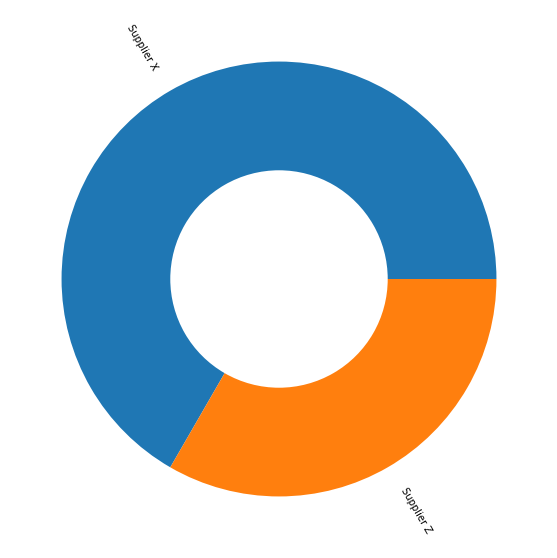

In [20]:
# Function to combine last few classes ito one 
import matplotlib.pyplot as plt
total_other_reviews = 0
def combine_last_n(df):
    df1 = df.copy()
    global total_other_reviews 
    total_other_reviews = (sum(df[df.number_of_reviews <= 5000].number_of_reviews))
    df1.loc[df.number_of_reviews <= 10000, 'number_of_reviews'] = 0
    return df1.number_of_reviews

f, ax = plt.subplots(figsize=(10, 10))

plot = complete_data[complete_data.solution>0].groupby('supp_name').\
    aggregate({'prod_name':'count'}).\
    sort_values('prod_name', ascending = False).\
    plot.pie(y='prod_name',  legend=None, rotatelabels=True, 
             wedgeprops=dict(width=.5), # for donut shape
            ax = ax)
plt.ylabel("")

In [17]:
complete_data['total_cost'] = complete_data.bid_cost + complete_data.other_cost + complete_data.trans_cost
complete_data['total_spends'] = complete_data.total_cost*complete_data.demand

complete_data.groupby('prod_name').aggregate({'total_spends':'mean'}).reset_index()['total_spends'].sum()

40150

In [48]:
prod_list = list(complete_data['prod_name'].unique())

In [59]:
heatmap_data = complete_data[['prod_name', 'supp_name', 'total_cost']].groupby(['supp_name', 'prod_name']).\
    aggregate({'total_cost':'mean'}).unstack().total_cost.rename_axis([None], axis=1).reset_index()
heatmap_data.index = heatmap_data['supp_name']
heatmap_data = (heatmap_data-heatmap_data.mean())/heatmap_data.std()

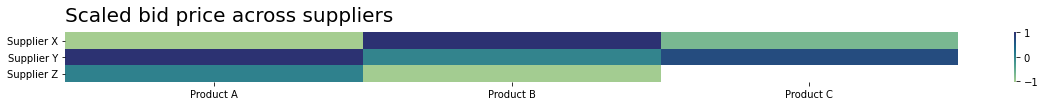

In [61]:
import seaborn as sns
fig, ax = plt.subplots(figsize=[20,len(heatmap_data)/3.3])
crest_cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(data=heatmap_data[prod_list], cmap = crest_cmap)
plt.title("Scaled bid price across suppliers", fontsize=20, y=1.1,loc='left')
ax.set_ylabel('')
plt.show()

In [58]:
(heatmap_data-heatmap_data.mean())/heatmap_data.std()

,Product A,Product B,Product C,supp_name
supp_name,,,,
Supplier X,-1.021466,1.0,-0.707107,NaN
Supplier Y,0.977054,0.0,0.707107,NaN
Supplier Z,0.044412,-1.0,NaN,NaN
